In [3]:
# Trung bình director_success_rate theo tconst
avg_director_score = (
    df_raw.groupby("tconst")["director_success_rate"]
    .mean()
    .reset_index()
    .rename(columns={"director_success_rate": "avg_director_success_rate"})
)

# Lấy bản ghi duy nhất theo tconst
df_unique = df_raw.drop_duplicates(subset="tconst").drop(columns=["nconst", "director_success_rate"])

# Merge trở lại
df = df_unique.merge(avg_director_score, on="tconst", how="left")

NameError: name 'df_raw' is not defined

In [ ]:
from google.cloud import bigquery
import pandas as pd

client = bigquery.Client(project="disney-success-predictor")

query = """
SELECT * FROM `disney-success-predictor.imdb_data.imdb_features_with_director`
"""
df_raw = client.query(query).to_dataframe()

In [ ]:
# One-hot genres
df['genres'] = df['genres'].str.split(',')
genres_df = df['genres'].explode().str.strip().str.get_dummies().groupby(level=0).sum()

# One-hot categorical: release_season, release_decade, release_window
release_season_df = pd.get_dummies(df['release_season'], prefix='season')
release_decade_df = pd.get_dummies(df['release_decade'], prefix='decade')
release_window_df = pd.get_dummies(df['release_window'], prefix='window')

# Gộp toàn bộ
df_final = pd.concat([
    df,
    genres_df,
    release_season_df,
    release_decade_df,
    release_window_df
], axis=1)

In [ ]:
features = (
    ['runtime_minutes', 'genre_count', 'is_adult', 'sequel_flag',
     'log_votes', 'franchise_flag', 'avg_director_success_rate']
    + list(genres_df.columns)
    + list(release_season_df.columns)
    + list(release_decade_df.columns)
    + list(release_window_df.columns)
)

X = df_final[features]
y = df_final['success']

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tính scale_pos_weight
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
weight = neg / pos

model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, scale_pos_weight=weight)
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [1]:
import joblib

# Save model
joblib.dump(model, 'xgb_movie_success_model.pkl')

# Download to your computer
from google.colab import files
files.download('xgb_movie_success_model.pkl')


NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      4065
         1.0       0.87      0.95      0.91      2012

    accuracy                           0.93      6077
   macro avg       0.92      0.94      0.93      6077
weighted avg       0.94      0.93      0.94      6077

ROC-AUC Score: 0.9859


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Giả sử bạn đã có xác suất dự đoán
y_proba = model.predict_proba(X_test)[:, 1]

# Chọn threshold
threshold = 0.65
y_pred_thresh = (y_proba >= threshold).astype(int)

# Đánh giá
print(f"Threshold = {threshold}")
print(classification_report(y_test, y_pred_thresh))

Threshold = 0.65
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95      4065
         1.0       0.90      0.92      0.91      2012

    accuracy                           0.94      6077
   macro avg       0.93      0.93      0.93      6077
weighted avg       0.94      0.94      0.94      6077



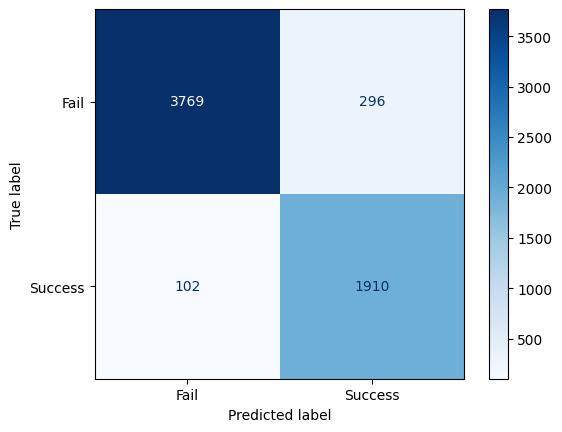

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fail", "Success"])
disp.plot(cmap='Blues', values_format='d')  # Hiển thị số nguyên

In [ ]:
import pickle

# Save the model to a .pkl file
with open('disney_success_model.pkl', 'wb') as file:
    pickle.dump(model, file)